In [1]:
import numpy as np

from utils import QueueBandit

In [2]:
N_CLASSES = 3

queue_bandit = QueueBandit(filename='data.csv')

# Greedy

In [3]:
class GreedyQueue:
    def __init__(self, n_classes=3):
        self.n_classes = n_classes
        self.time_history = [[] for _ in range(n_classes)]
    
    def decide(self, queue_lengths):
        for class_ in range(self.n_classes):
            if queue_lengths[class_] > 0 and len(self.time_history[class_]) == 0:
                return class_
            
        mean_times = [
            np.mean(self.time_history[class_])
            if queue_lengths[class_] > 0 else np.inf
            for class_ in range(self.n_classes)
        ]
        
        return int(np.random.choice(
            np.argwhere(mean_times == np.min(mean_times)).flatten()
        ))
    
    def update(self, class_, time):
        self.time_history[class_].append(time)

100%|██████████| 50/50 [00:01<00:00, 43.86it/s]


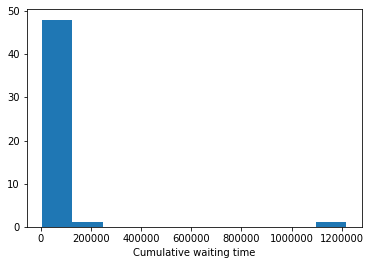

(1218887.7924350922, 45155.236786598274)

In [4]:
cumulative_times = queue_bandit.repeat(
    GreedyQueue, [N_CLASSES], visualize_cumulative_times=True
)

np.max(cumulative_times), np.mean(cumulative_times)

# Explore-then-commit

In [5]:
class ETCQueue:
    def __init__(self, n_classes=3, T=3):
        self.n_classes = n_classes
        self.T = T
        self.time_history = [[] for _ in range(n_classes)]
    
    def decide(self, queue_lengths):
        for class_ in range(self.n_classes):
            if queue_lengths[class_] > 0 and len(self.time_history[class_]) < self.T:
                return class_
            
        mean_times = [
            np.mean(self.time_history[class_])
            if queue_lengths[class_] > 0 else np.inf
            for class_ in range(self.n_classes)
        ]
        
        return int(np.random.choice(
            np.argwhere(mean_times == np.min(mean_times)).flatten()
        ))
    
    def update(self, class_, time):
        self.time_history[class_].append(time)

100%|██████████| 50/50 [00:01<00:00, 43.35it/s]


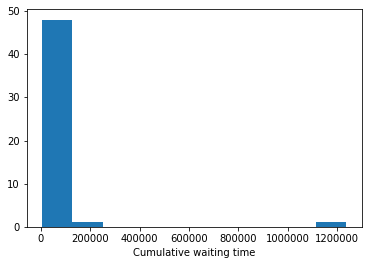

(1238591.3208636027, 45909.77140562623)

In [6]:
cumulative_times = queue_bandit.repeat(
    ETCQueue, [N_CLASSES, 2], visualize_cumulative_times=True
)

np.max(cumulative_times), np.mean(cumulative_times)

# Thompson sampling

In [7]:
class ExpThSQueue:
    def __init__(self, n_classes=3):
        self.n_classes = n_classes
        self.time_history = [[] for _ in range(n_classes)]
        self.temp_beliefs = [(0, 0) for _ in range(n_classes)]
        
    def decide(self, queue_lengths):
        for class_ in range(self.n_classes):
            if queue_lengths[class_] > 0 and len(self.time_history[class_]) == 0:
                return class_
        
        rate_draws = [
            np.random.gamma(
                self.temp_beliefs[class_][0],
                1 / self.temp_beliefs[class_][1]
            )
            if queue_lengths[class_] > 0 else -np.inf
            for class_ in range(self.n_classes)
        ]
        
        return int(np.random.choice(
            np.argwhere(rate_draws == np.max(rate_draws)).flatten()
        ))
            
    def update(self, class_, time):
        self.time_history[class_].append(time)
        
        # Update parameters according to Bayes rule
        alpha, beta = self.temp_beliefs[class_]
        alpha += 1
        beta += time
        self.temp_beliefs[class_] = alpha, beta

100%|██████████| 50/50 [00:00<00:00, 52.07it/s]


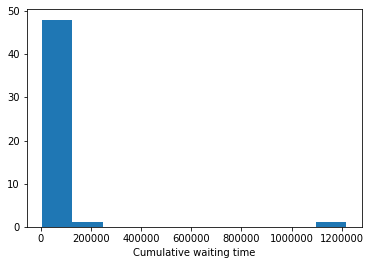

(1218887.7924350922, 45129.343871806814)

In [8]:
cumulative_times = queue_bandit.repeat(
    ExpThSQueue, [N_CLASSES], visualize_cumulative_times=True
)

np.max(cumulative_times), np.mean(cumulative_times)

# Exploiting ThS

In [9]:
class ExploitingThSQueue:
    def __init__(self, n_classes=3, r=1):
        self.n_classes = n_classes
        self.time_history = [[] for _ in range(n_classes)]
        self.temp_beliefs = [(0, 0) for _ in range(n_classes)]
        self.t = 0
        self.r = r
        
    def decide(self, queue_lengths):
        for class_ in range(self.n_classes):
            if queue_lengths[class_] > 0 and len(self.time_history[class_]) == 0:
                return class_
            
        if self.t > self.r * np.sum(queue_lengths):
            mean_times = [
                np.mean(self.time_history[class_])
                if queue_lengths[class_] > 0 else np.inf
                for class_ in range(self.n_classes)
            ]

            return int(np.random.choice(
                np.argwhere(mean_times == np.min(mean_times)).flatten()
            ))
        
        rate_draws = [
            np.random.gamma(
                self.temp_beliefs[class_][0],
                1 / self.temp_beliefs[class_][1]
            )
            if queue_lengths[class_] > 0 else -np.inf
            for class_ in range(self.n_classes)
        ]
        
        return int(np.random.choice(
            np.argwhere(rate_draws == np.max(rate_draws)).flatten()
        ))
            
    def update(self, class_, time):
        self.time_history[class_].append(time)
        self.t += 1
        
        # Update parameters according to Bayes rule
        alpha, beta = self.temp_beliefs[class_]
        alpha += 1
        beta += time
        self.temp_beliefs[class_] = alpha, beta

100%|██████████| 50/50 [00:01<00:00, 40.76it/s]


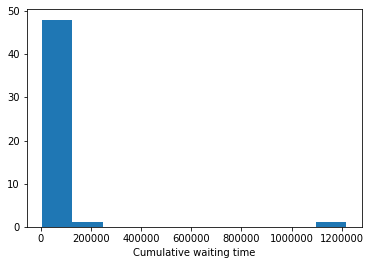

(1218887.7924350922, 45093.244027644556)

In [10]:
cumulative_times = queue_bandit.repeat(
    ExploitingThSQueue, [N_CLASSES, 1], visualize_cumulative_times=True
)

np.max(cumulative_times), np.mean(cumulative_times)